# IMPRORT

In [1]:
from typing import Any
from py3.k_means import PixelValueGenerator, CustomKMeans
import numpy as np
from py3.CNN_model import Cplx_CustomCNN_1D
from py3.Attention_Layer import CustomAttentionLayer, AttentionLayer
from py3.classification import CustomClassifierModel
import tensorflow as tf

import re
import numpy as np
import pandas as pd

In [2]:
class Color:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    END = '\033[0m'

In [3]:
df = pd.read_csv('Prepro_Data/post_processed_data.csv')
print(df.head())

import pandas as pd
import numpy as np

def extract_multiple_arrays(string_repr):
    # Remove letters, parentheses, spaces, and unwanted sequences
    string_repr = re.sub('[a-df-zA-DF-Z\(\)\s]', '', string_repr)
    string_repr = re.sub(r',=32', '', string_repr)

    # Find all matches of arrays within the string
    arrays = re.findall(r'\[.*?\]', string_repr)

    # Convert each found array string into a NumPy array
    #np_arrays = [np.array(re.findall(r'[+-]?\d+(?:\.\d+)?', array), dtype=float) for array in arrays]
    np_arrays = [np.array(re.findall(r'[+-]?\d+(?:\.\d+)?(?:e[+-]?\d+)?', array), dtype=float) for array in arrays]
    return np_arrays


   Unnamed: 0  segment_id  polygon_id  class_id  \
0           0      367854         0.0       3.0   
1           1      367855         0.0       3.0   
2           2      367856         0.0       3.0   
3           3      369130         0.0       3.0   
4           4      363215         1.0       1.0   

                                              pixels  
0  [[0.44984567, 0.49691358, 0.40354937, 0.622685...  
1  [[0.55632716, 0.5578704, 0.50848764, 0.7075617...  
2  [[0.53780866, 0.5671296, 0.4699074, 0.69058645...  
3  [[0.5231481, 0.5532407, 0.44984567, 0.6705247,...  
4  [[0.38194445, 0.43904322, 0.24845679, 0.493055...  


class_id
5    1403
6    1089
4     795
1     544
3     427
2     409
8      72
7      56
Name: count, dtype: int64


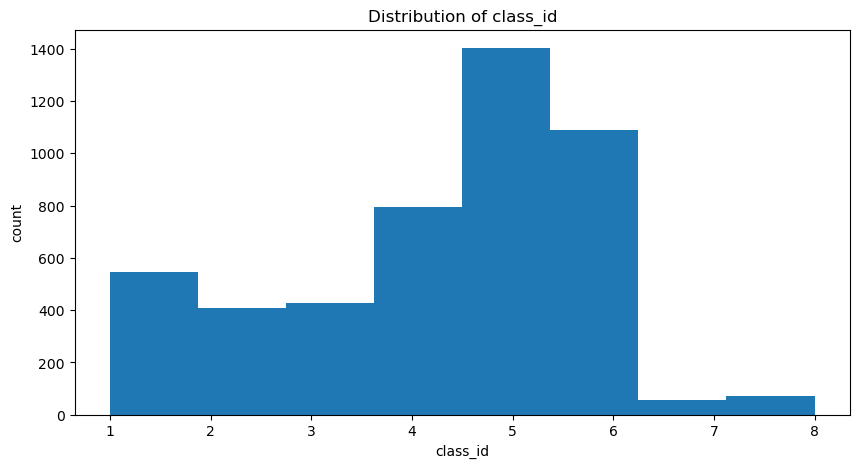

In [4]:
# Distribution of class_id
df['class_id'] = df['class_id'].astype('int8')
print(df['class_id'].value_counts())
 
# Plot the distribution of class_id
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['class_id'], bins=8)
plt.title('Distribution of class_id')
plt.xlabel('class_id')
plt.ylabel('count')
plt.show()

In [5]:
# Apply the function to the 'pixels' column
df['pixels'] = df['pixels'].apply(extract_multiple_arrays)

In [6]:
print(df.head())

   Unnamed: 0  segment_id  polygon_id  class_id  \
0           0      367854         0.0         3   
1           1      367855         0.0         3   
2           2      367856         0.0         3   
3           3      369130         0.0         3   
4           4      363215         1.0         1   

                                              pixels  
0  [[0.44984567, 0.49691358, 0.40354937, 0.622685...  
1  [[0.55632716, 0.5578704, 0.50848764, 0.7075617...  
2  [[0.53780866, 0.5671296, 0.4699074, 0.69058645...  
3  [[0.5231481, 0.5532407, 0.44984567, 0.6705247,...  
4  [[0.38194445, 0.43904322, 0.24845679, 0.493055...  


In [6]:
stacked_arrays = []

# Stack the arrays for each cell
for cell_pixels in df['pixels']:
    stacked_array = np.vstack(cell_pixels)
    stacked_arrays.append(stacked_array)

In [7]:
n_clusters=3
custom_kmeans = CustomKMeans(n_clusters=n_clusters)

clustered_data = []

for i in range (len(stacked_arrays)):
    custom_kmeans.fit(stacked_arrays[i])
    clustered_data.append(custom_kmeans.get_cluster_centers())

/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thibaultgillard/miniconda3/envs/tensorflow/lib/python3.10/si

In [8]:
clusters = np.array(clustered_data)
print("clusters shape:", clusters.shape)
labels = np.array(df['class_id'])- 1
# remove last class and cluster with that class


from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Split the data into training and testing sets, with stratification
train_data, test_data, train_labels, test_labels = train_test_split(
    clusters, labels, test_size=0.2, random_state=42 
)
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
#print hte different possible labels
print("labels:", np.unique(labels))


clusters shape: (4795, 3, 73, 10)
train_data shape: (3836, 3, 73, 10)
train_labels shape: (3836, 8)
labels: [0 1 2 3 4 5 6 7]


In [41]:
class Custom_Model(tf.keras.Model):
    
    def __init__(self):
        super(Custom_Model, self).__init__()
        self.enc = Cplx_CustomCNN_1D()
        self.attn = AttentionLayer()
        self.classifier = CustomClassifierModel(num_classes=8, fc_units=64) 

    def call(self, inputs):
        
        input_list = tf.unstack(inputs,axis=1) # from tensor to list
        intermediate = [self.enc(input) for input in input_list]
        intermediate = tf.stack(intermediate,axis=1)        
        emb, alphas = self.attn(intermediate)
        
        return self.classifier(emb)
    
    def summary(self):
        self.enc.summary()
        #self.attn.summary()
        #self.classifier.summary()

In [42]:
from keras.optimizers.legacy import Adam as Adam_legacy
from keras.optimizers import Adam

lr = 0.001

model = Custom_Model()
optimizer = Adam_legacy(learning_rate=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print(test_data.shape)
history = model.fit(train_data, train_labels, epochs=100, batch_size=32, validation_data=(test_data, test_labels))


(959, 3, 73, 10)
Epoch 1/100
120/120 [==============================] - 21s 125ms/step - loss: 1.8943 - accuracy: 0.3287 - val_loss: 1.9673 - val_accuracy: 0.1606
Epoch 2/100
120/120 [==============================] - 13s 107ms/step - loss: 1.5739 - accuracy: 0.4088 - val_loss: 1.6909 - val_accuracy: 0.3608
Epoch 3/100
120/120 [==============================] - 13s 106ms/step - loss: 1.4844 - accuracy: 0.4351 - val_loss: 1.5971 - val_accuracy: 0.3358
Epoch 4/100
120/120 [==============================] - 13s 106ms/step - loss: 1.4038 - accuracy: 0.4549 - val_loss: 1.6815 - val_accuracy: 0.3921
Epoch 5/100
120/120 [==============================] - 13s 106ms/step - loss: 1.3710 - accuracy: 0.4729 - val_loss: 1.8957 - val_accuracy: 0.2607
Epoch 6/100
120/120 [==============================] - 13s 106ms/step - loss: 1.3074 - accuracy: 0.4917 - val_loss: 1.5619 - val_accuracy: 0.4150
Epoch 7/100
120/120 [==============================] - 13s 105ms/step - loss: 1.2634 - accuracy: 0.5149 - v

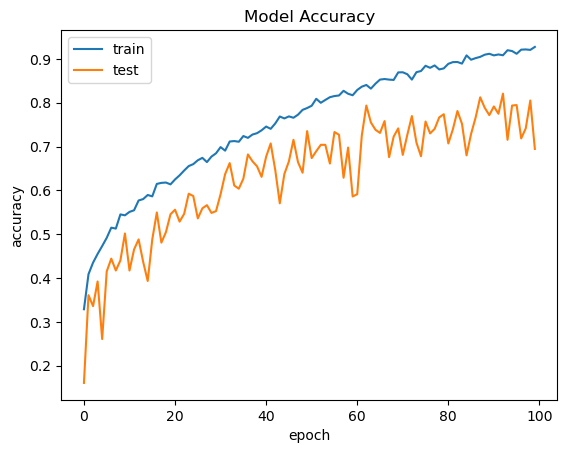

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
from py3.CNN_model import Cplx_CustomCNN_1D, New_CustomCNN1D
 
class New_Custom_Model(tf.keras.Model):
    
    def __init__(self):
        super(New_Custom_Model, self).__init__()
        self.enc = New_CustomCNN1D()
        self.attn = AttentionLayer()
        self.classifier = CustomClassifierModel(num_classes=8, fc_units=64)

    def call(self, inputs):
        
        input_list = tf.unstack(inputs,axis=1) # from tensor to list
        intermediate = [self.enc(input) for input in input_list]
        intermediate = tf.stack(intermediate,axis=1)        
        emb, alphas = self.attn(intermediate)
                
        return self.classifier(emb)
    
    def summary(self):
        self.enc.summary()
        #self.attn.summary()
        #self.classifier.summary()


In [10]:
from keras.optimizers.legacy import Adam as Adam_legacy
from keras.optimizers import Adam

lr = 0.001

model = New_Custom_Model()
optimizer = Adam_legacy(learning_rate=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print(test_data.shape)
history = model.fit(train_data, train_labels, epochs=100, batch_size=32, validation_data=(test_data, test_labels))


2023-12-06 01:12:26.976618: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-06 01:12:26.976663: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-06 01:12:26.976666: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-06 01:12:26.977004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 01:12:26.977177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(959, 3, 73, 10)
Epoch 1/100


2023-12-06 01:12:28.557931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 7s 34ms/step - loss: 1.8333 - accuracy: 0.3107 - val_loss: 1.9719 - val_accuracy: 0.4119
Epoch 2/100
120/120 [==============================] - 4s 29ms/step - loss: 1.3627 - accuracy: 0.5018 - val_loss: 1.9093 - val_accuracy: 0.2941
Epoch 3/100
120/120 [==============================] - 3s 28ms/step - loss: 1.2064 - accuracy: 0.5508 - val_loss: 1.8362 - val_accuracy: 0.3525
Epoch 4/100
120/120 [==============================] - 3s 29ms/step - loss: 1.0606 - accuracy: 0.6090 - val_loss: 1.7789 - val_accuracy: 0.3858
Epoch 5/100
120/120 [==============================] - 3s 29ms/step - loss: 0.9977 - accuracy: 0.6249 - val_loss: 3.6120 - val_accuracy: 0.2294
Epoch 6/100
120/120 [==============================] - 3s 29ms/step - loss: 0.9101 - accuracy: 0.6598 - val_loss: 4.2782 - val_accuracy: 0.2284
Epoch 7/100
120/120 [==============================] - 3s 29ms/step - loss: 0.8583 - accuracy: 0.6681 - val_loss: 2.0344 - val_accuracy: 0.3618
Epoc

In [ ]:
import tensorflow as tf

labels = np.array(df['class_id'])- 1
# list of weights for each class
weights = [1/np.sum(labels==i) for i in range(8)]
print(weights)

def weighted_categorical_crossentropy(weights):
    weights = tf.convert_to_tensor(weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, weights)
        return tf.reduce_mean(loss)
    
    return loss

[0.002061855670103093, 0.0029498525073746312, 0.002849002849002849, 0.0013297872340425532, 0.0015174506828528073, 0.002564102564102564, 0.02040816326530612, 0.07142857142857142]


In [ ]:
lr = 0.001
model = Custom_Model()
optimizer = Adam_legacy(learning_rate=lr)
model.compile(optimizer=optimizer, loss=weighted_categorical_crossentropy(weights), metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=6, batch_size=16, validation_data=(test_data, test_labels))

Epoch 1/6
152/152 [==============================] - 200s 1s/step - loss: 0.6294 - accuracy: 0.7014 - val_loss: 0.6682 - val_accuracy: 0.1447
Epoch 2/6
152/152 [==============================] - 205s 1s/step - loss: 0.6229 - accuracy: 0.7914 - val_loss: 0.6678 - val_accuracy: 0.1924
Epoch 3/6
152/152 [==============================] - 196s 1s/step - loss: 0.6224 - accuracy: 0.7931 - val_loss: 0.6698 - val_accuracy: 0.1661
Epoch 4/6
152/152 [==============================] - 196s 1s/step - loss: 0.6200 - accuracy: 0.8272 - val_loss: 0.6771 - val_accuracy: 0.0477
Epoch 5/6
152/152 [==============================] - 199s 1s/step - loss: 0.6171 - accuracy: 0.8643 - val_loss: 0.6647 - val_accuracy: 0.2385
Epoch 6/6
152/152 [==============================] - 203s 1s/step - loss: 0.6159 - accuracy: 0.8811 - val_loss: 0.6719 - val_accuracy: 0.1234


[0.002061855670103093, 0.0029498525073746312, 0.002849002849002849, 0.0013297872340425532, 0.0015174506828528073, 0.002564102564102564, 0.02040816326530612, 0.07142857142857142]
